In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import subprocess
from scipy.signal import savgol_filter


In [31]:
def find(reg,linhas):
    #cria a lista que vai ser retornada como resultado da funcao com a palavra e seu valor
    busca_resultado=[]
    #for para varrer todas as linhas, o valor de i indica qual á linha em linhas[i]
    for i in range(len(linhas)):
        #for para varrer cada linha a procura da palavra buscada
        for item in linhas[i]:
            #verifica se o registro esta na linha
            if item == reg:
                #este for e para varrer novamente a linha se achar o registro para gravar todos os valores da linha em uma lista
                for item in linhas[i]:
                    if item != reg:
                        busca_resultado.append(item)
    return busca_resultado

def find_n_line(reg,linhas):
    #cria a lista que vai ser retornada como resultado da funcao com a palavra e seu valor
    busca_resultado=[]
    #for para varrer todas as linhas, o valor de i indica qual á linha em linhas[i]
    j=0
    for i in range(0,len(linhas)):
        #for para varrer cada linha a procura da palavra buscada
        for item in linhas[i]:
            #verifica se o registro esta na linha
            if item == reg:
                #este for e para varrer novamente a linha se achar o registro para gravar todos os valores da linha em uma lista
                    busca_resultado.append(j)
        j+=1
    return busca_resultado

def open_file(name):                                    #function that transform file in to list. input name: path and the name of the file.
    file = open(name,'r',encoding='utf-8',
                 errors='ignore')                               #open the file.
    file_list = []                                      #creat a list that will be full filed with the file with a line as a list element.
    for line in file:                                   #open a loop that cover the file.
        line = line.strip('\n')                         #drop out all '\n' contained in every line.
        line = line.split()                             #change the spaces for a element of a list, ex: 'the energy is' --> ['the','energy','is'].
        file_list.append(line)                          #add the line in the list file_list.
    file.close()                                        #close de file.
    return file_list        

def change_coluns_pdos(arquivo):
    # abre o arquivo scf.out
    arq = open(arquivo, 'r')
    # cria a lista que contenhaa cada linha do arquvio cif como um elemento da lista
    new_arq = []
    ct=0
    for linha in arq:
        # retira o \n de quebra de linnha da linha
        line = linha.strip('\n')
        # retira os espaços entre os elementos da linha, assim criando uma lista
        line = line.split()
        if ct == 0 and line[0] == '#':
            line.remove('#')
            new_line = []
            for item in line:
                if item != '(eV)':
                    new_line.append(item)
        else:
                new_line = line
        new_arq.append(new_line)
        ct+=1
    # fecha o arquivo
    arq.close()
    return 0

def atoms(arquivo):
    # abre o arquivo scf.out
    scf_arq = open(arquivo, 'r')
    # cria a lista que contenhaa cada linha do arquvio cif como um elemento da lista
    scf = []
    ct=0
    for linha in scf_arq:
        # retira o \n de quebra de linnha da linha
        line = linha.strip('\n')
        # retira os espaços entre os elementos da linha, assim criando uma lista
        line = line.split()
        for item in line:
            if item== 'ATOMIC_SPECIES':
                contador1 = ct+1
            elif item== 'ATOMIC_POSITIONS':
                contador2 = ct
        # grava a linha na lista linhas
        scf.append(line)
        ct+=1
    # fecha o arquivo
    scf_arq.close()
    atom =[]
    for i in range(contador1,contador2):
        atom.append(scf[i][0])
    return atom
    
def E_fermi(scf_arq):  
    for line in scf_arq:
        for item in line:
            if item == "Fermi":
                E_f = round(float(line[4]),4)
            elif item == "occupied":
                E_f = round(float(line[4]),4)
    return E_f

def arquivos_pdos(pasta_pdos,prefix_exist,prefix):
    pdos_arquivos = []
    pdos =[]
    pdos_nomes = []
    for diretorio, subpastas,arquivos in os.walk(pasta_pdos):
        if prefix_exist == True:
            prefixo = prefix
            for arquivo in arquivos:
                if arquivo[:len(prefixo)]==prefixo and arquivo != prefixo+'.pdos.dat.pdos_tot' and arquivo != prefixo+'.pdos-proj.dat.projwfc_up':
                    nome = ''
                    for caracter in arquivo:
                        if caracter != '#':
                            nome+=caracter
                    if os.path.join(pasta_pdos,arquivo) == os.path.join(pasta_pdos,nome):
                        pdos_arquivos.append(os.path.join(pasta_pdos,nome))
                    else:
                        subprocess.run(['mv',os.path.join(pasta_pdos,arquivo),os.path.join(pasta_pdos,nome)])
                        pdos_arquivos.append(os.path.join(pasta_pdos,nome))
        else:
            for arquivo in arquivos:
                if arquivo[:4]=='pdos' and  arquivo != 'pdos.dat.pdos_tot' and arquivo != 'pdos-proj.dat.projwfc_up':
                    nome = ''
                    for caracter in arquivo:
                        if caracter != '#':
                            nome+=caracter
                    if os.path.join(pasta_pdos,arquivo) == os.path.join(pasta_pdos,nome):
                        pdos_arquivos.append(os.path.join(pasta_pdos,nome))
                    else:
                        subprocess.run(['mv',os.path.join(pasta_pdos,arquivo),os.path.join(pasta_pdos,nome)]) #linux 
                        #subprocess.run(['mv',os.path.join(pasta_pdos,arquivo),os.path.join(pasta_pdos,nome)],shell = True, text = True) #windows 
                        #subprocess.run("mv "+os.path.join(pasta_pdos,arquivo)+" "+os.path.join(pasta_pdos,nome),shell = True)
                        pdos_arquivos.append(os.path.join(pasta_pdos,nome))
    return pdos_arquivos

def atomos_arquivo(atomos,pdos_arquivos):
#separando por atomos
    atomos_arquivos = {}
    count = 0
    for a in range(len(atomos)):
        lista =[]
        for nome in pdos_arquivos:
            for i in range(len(nome)):
                if len(atomos[a]) == 1:
                    if nome[i] == '('  and nome[i+1]==atomos[a]:
                        lista.append(nome)
                else:
                    if nome[i]==atomos[a][0] and nome[i+1]== atomos[a][1] :
                        lista.append(nome)
        atomos_arquivos[atomos[a]]=lista
    return atomos_arquivos

def atomos_orbitais(atomos,pdos_arquivos):
#separando por atomos
    atomos_arquivos = {}
    count = 0
    dict = atomos_arquivo(atomos,pdos_arquivos)
    for a in range(len(atomos)):
        lista =[]
        for nome in dict[atomos[a]]:
            for i in range(len(nome)):
                if nome[i] == '('  and nome[i+1]=='s':
                        if (nome[i+1] in lista) == False:
                            lista.append(nome[i+1])
                elif nome[i] == '('  and nome[i+1]=='p':
                        if (nome[i+1] in lista) == False:
                            lista.append(nome[i+1])
                elif nome[i] == '('  and nome[i+1]=='d':
                        if (nome[i+1] in lista) == False:
                            lista.append(nome[i+1])     
        atomos_arquivos[atomos[a]]=lista
    return atomos_arquivos

def atom_orb_arquivos(atomos,pdos_arquivos,atomos_orbitais,atomos_arquivo):
    atom_orb_dict = {}
    for atom in atomos:
        atomos_arq = atomos_arquivo(atomos,pdos_arquivos)
        orb=atomos_orbitais(atomos,pdos_arquivos)
        atom_orb_dict[atom]={}
        for item in orb[atom]:
            atom_orb_dict[atom][item]=[]
            lista =[]
            for arq in atomos_arq[atom]:
                for i in range(len(arq)):
                    if arq[i]=='(' and arq[i+1] == item:
                        lista.append(arq)
            atom_orb_dict[atom][item]=lista
    return atom_orb_dict

def bandas_df(arquivo):
    bandas=pd.read_csv(arquivo,delim_whitespace=True,names=['k','E'],dtype=float)
    #subtrai todos os valores pelo nivel de fermi
    return bandas

def orbitais(bandas,ef,Ef):
    #nesse bloco sera feito a separaçao do data frame em varias colunas, onde cada coluna é referente a uma banda
    #neste passo vamos obter do dataFrame Bandas original apenas os valores de momento que nao são repetidos
    #cria a lista para armazenaros valroes
    if ef == True:
        bandas['E']-=Ef
    momentos=[]
    #for para varrer todos os indices do dataframe
    for i in bandas.index:
        #pega o valor do momento para o indice i, no caso a linha i do data frame
        mom=bandas.loc[i][0]
        #cria uma condicao para adicionar na lista apenas itens nao repetidos, ou seja se mom nao estiver na  lista momentos, entao ele sera adicionado a mesma, caso contrario nada e feito 
        condicao=mom in momentos
        if condicao == False:
            momentos.append(mom)
    #variavel para fazer a contagem total do numero de bandas
    n_bnd=0
    #para fazer a contagem vamso pegar todos os valores de k na coluna "k" do dataframe Bandas, sempre que k=0, quer dize que começamos uma nova banda, portanto a 
    #condicao de troca de bandas sera quando k=0, sempre que isso acontecer, adicionamos +1 no valor de n_bnd(numero de bandas)
    cond=bandas["k"]==0
    #começa o for varrendo todos os valores de k contidos na coluna bandas["k"]
    for item in cond:
        if item==True:
            n_bnd+=1
        else:
            pass
    #cria o novo dataFrame com a coluna contendo apenas os valores de k que nao sao repetidos   
    df=pd.DataFrame(momentos,columns=["K"],dtype=float)
    #começa com o menor valor posivel para a energia da banda de valencia
    E_valencia=min(bandas['E'])
    #começa com o maior valor posivel para a energia da banda de conduçao
    E_conducao=max(bandas['E'])
    #loop para varrer todas as bandas do data frame
    for j in range(n_bnd):
        #cria a lista que vai armazear os valores de energia para a banda j
        energia=[]
        #loop para varrer todos os valores de energia contidos no dataframe original que coresponem a banda j
        for i in range(len(momentos)):
            e=bandas.loc[i+j*len(momentos)][1]
            energia.append(e)
        #cria uma nova coluna no novo dataframe adicionando todos os valores de energia da banda j
        df["orb "+str(j)]=energia
        #atualiza o valor da energia de valencia
        if ef == True:
            if max(energia)>=E_valencia and max(energia)<=Ef:
                E_valencia=max(energia)
            #atualiza o valor da energia de conduçao
            elif min(energia)<=E_conducao and min(energia)>=Ef:
                E_conducao=min(energia)
        else:
            if max(energia)>=E_valencia and max(energia)<=0:
                E_valencia=max(energia)
            #atualiza o valor da energia de conduçao
            elif min(energia)<=E_conducao and min(energia)>=0:
                E_conducao=min(energia)
    return [df,E_valencia,E_conducao]

def k_point(bandin_file):   
    k_points_band = []
    k_points_letter = []
    i = 0
    for line in bandin_file:
        if len(line)>=1:
            if line[0] == 'K_POINTS':
                n_line = i
        i+=1
    n_kpoints = int(bandin_file[n_line+1][0] )
    for i in range(n_line+2,n_line+2+n_kpoints):
        k_points_band.append(np.array(bandin_file[i][:3],dtype=float))
        if bandin_file[i][4][1:] == 'G':
            k_points_letter.append('$\Gamma$')
        else:
            k_points_letter.append(bandin_file[i][4][1:])
    return [k_points_letter,k_points_band]

def k_points_path(file,n_k):
    i = 0
    k_points_bandsx = []
    k_path = []
    for line in file:
        for item in line:
            if item == 'wavefunctions':
                n_line = i+1
        i+=1
    for j in range(n_line,n_line + n_k):
        k_points_bandsx.append(np.array(file[j][2:5],dtype=float))
        k_path.append(float(file[j][7]))
    return [k_path,k_points_bandsx]



In [32]:
class File:                                                                    #this class is relative to treatement of the raw data in to a better analize format 
    def __init__(self):                                                        #load the input file
        self.scf_dir = 'pdos'
        self.pdos_dir = 'pdos'
        self.bands_dir = 'bands'
        self.scfin_file_name = 'scf.in'
        self.scfout_file_name = 'scf.out'
        self.bandin_file_name = 'bands.in'
        self.bandout_file_name = 'bands.out'
        self.bandxout_file_name = 'bands.x.out'
        self.band_file_name = 'bands.dat.gnu'
        self.dos_file_name = 'pdos.dat.pdos_tot'

    def load(self):
        self.scfin_file_path = os.path.join(self.scf_dir,self.scfin_file_name)
        self.scfin_file = open_file(self.scfin_file_path)

        self.scfout_file_path = os.path.join(self.scf_dir,self.scfout_file_name)
        self.scfout_file = open_file(self.scfout_file_path)
        self.fermy_energy = E_fermi(self.scfout_file)

    def Bands(self,fermi_energy_corr = True):
        self.band_file_path = os.path.join(self.bands_dir,self.band_file_name)
        bands = bandas_df(self.band_file_path)
        self.bands,self.E_valencia,self.E_conducao = orbitais(bands,fermi_energy_corr ,self.fermy_energy) 

        self.bandin_file_path = os.path.join(self.bands_dir,self.bandin_file_name)
        self.bandin_file = open_file(self.bandin_file_path)
        self.k_points_letter, self.k_points_bands = k_point(self.bandin_file)

        self.bandxout_file_path = os.path.join(self.bands_dir,self.bandxout_file_name)
        self.bandxout_file = open_file(self.bandxout_file_path)
        self.k_path, self.k_points_bandsx = k_points_path(self.bandxout_file,len(self.k_points_letter))

    
    def DoS(self,fermi_energy_corr = True):  #dos via projwfc.x, nao usar dos.x

        self.dos_file_path = os.path.join(self.pdos_dir,self.dos_file_name)
        change_coluns_pdos(self.dos_file_path)
        self.dos_file = open_file(self.dos_file_path)
        self.dos = pd.DataFrame(self.dos_file)
        self.dos = self.dos.drop(0)
        self.dos = self.dos.rename(columns={0:'E',1:'dos',2:'pdos'})
        self.dos = self.dos.astype(float)
        if fermi_energy_corr == True:
            self.dos[self.dos.columns[0]] -= self.fermy_energy
        elif fermi_energy_corr == False:
            pass
        else:
            print('Wrong value for fermi_energy_corr parameter, only True or False values are accepted. Default = True')       

    def pdos(self, prefix_exist = False, prefix = '',fermi_energy_corr = True):
        self.pdos_per_atoms_files = atomos_arquivo(atoms(self.scfin_file_path),arquivos_pdos(self.pdos_dir,prefix_exist ,prefix))
        list_pdos = {}
        for key in self.pdos_per_atoms_files.keys():
            i=0
            for item in self.pdos_per_atoms_files[key]:
                if i ==0:
                    df = pd.read_csv(item,delim_whitespace=True,dtype=float)
                else:
                    df2 = pd.read_csv(item,delim_whitespace=True,dtype=float)
                    df[df.columns[1]]+=df2[df2.columns[1]]
                i+=1
            df.drop(df.columns[2:],axis = 'columns',inplace= True)
            if fermi_energy_corr == True:
                df[df.columns[0]] -= self.fermy_energy
                list_pdos[key] = df
                del(df)
            elif fermi_energy_corr == False:
                list_pdos[key] = df
                del(df)
            else:
                print('Wrong value for fermi_energy_corr parameter, only True or False values are accepted. Default = True')

        self.pdos_per_atoms = list_pdos
        

        self.pdos_per_orb_files = atom_orb_arquivos(atoms(self.scfin_file_path),arquivos_pdos(self.pdos_dir,prefix_exist ,prefix),atomos_orbitais,atomos_arquivo)
        dict = {}
        for key1 in self.pdos_per_orb_files.keys():
            dict[key1] ={}
            for key2 in self.pdos_per_orb_files[key1]:
                i=0
                for item in self.pdos_per_orb_files[key1][key2]:
                    if i==0:
                        df = pd.read_csv(item,delim_whitespace=True,dtype=float)
                    else:
                        df2 = pd.read_csv(item,delim_whitespace=True,dtype=float)
                        df[df.columns[1]]+=df2[df2.columns[1]]
                    i+=1
                df.drop(df.columns[2:],axis = 'columns',inplace= True)
                if fermi_energy_corr == True:
                    df[df.columns[0]] -= self.fermy_energy
                    dict[key1][key2] = df
                    del(df)
                elif fermi_energy_corr == False:
                    dict[key1][key2] = df
                    del(df)
                else:
                    print('Wrong value for fermi_energy_corr parameter, only True or False values are accepted. Default = True')                
        self.pdos_per_orb = dict
        

    def add_dos(self,dos_file_path):
        change_coluns_pdos(dos_file_path)
        dos_file_temp = open_file(dos_file_path)
        dos_new= pd.DataFrame(dos_file_temp)
        dos_new = dos_new.drop(0)
        dos_new = dos_new.rename(columns={0:'E',1:'dos',2:'pdos'})
        dos_new = dos_new.astype(float)
        return dos_new

    

class Plot:
    def dos(self, data,subplotsize = (10,8),subplot = False, ax =None ):
        if subplot == False:
            del(ax)
            fig, ax = plt.subplots(figsize=subplotsize)
        energy = data[data.columns[0]]; dos = data[data.columns[1]]
        ax.plot(energy,dos)
        return ax

    def pdos_atoms(self,dict,subplotsize = (10,8),subplot = False, ax =None):
        if subplot == False:
            del(ax)
            fig, ax = plt.subplots(figsize=subplotsize)
        for key in dict.keys():
            data = dict[key]
            x = data[data.columns[0]]; y = data[data.columns[1] ]
            ax.plot(x,y)
        return ax

    def pdos_orb(self,dict,subplotsize = (10,8),subplot = False, ax =None):
        if subplot == False:
            del(ax)
            fig, ax = plt.subplots(figsize=subplotsize)
        for key1 in dict.keys():
            for key2 in dict[key1].keys():
                data = dict[key1][key2]
                x = data[data.columns[0]]; y = data[data.columns[1] ]
                ax.plot(x,y,label = key1+key2)
        ax.legend()
        return ax              
        
    def bands(self,data,k_points_letter,k_path,subplotsize = (10,8),subplot = False, ax =None ):
        if subplot == False:
            del(ax)
            fig, ax = plt.subplots(figsize=subplotsize)
        columns = data.columns
        k = data[columns[0]]
        for i in range(1,len(columns)):
            energy = data[columns[i]]
            ax.plot(k,energy, color = 'black')  
        ax.set_xticks(k_path,k_points_letter)    


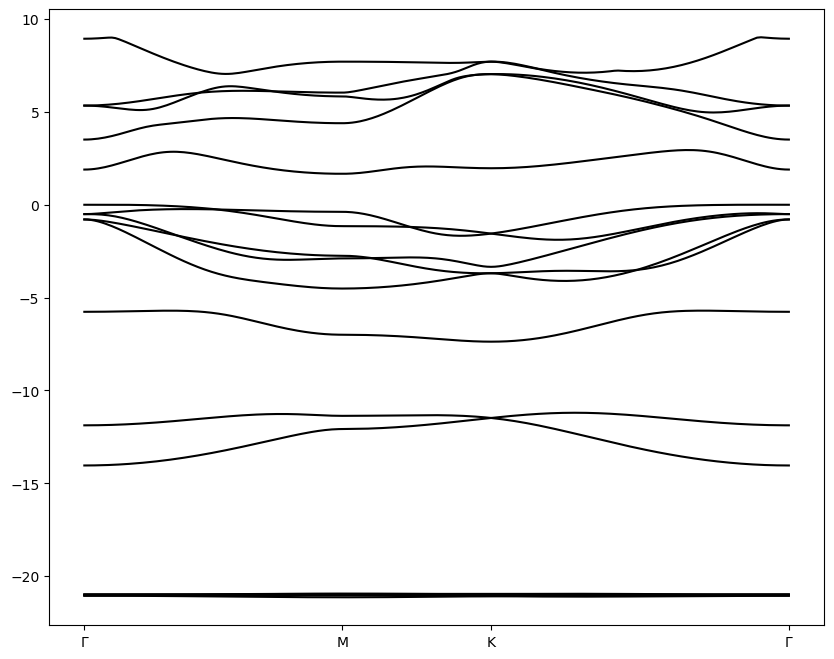

In [36]:
file = File()
file.scf_dir = 'bands'
file.load()
file.Bands()
plot = Plot()
plot.bands(file.bands,file.k_points_letter,file.k_path)

<AxesSubplot: >

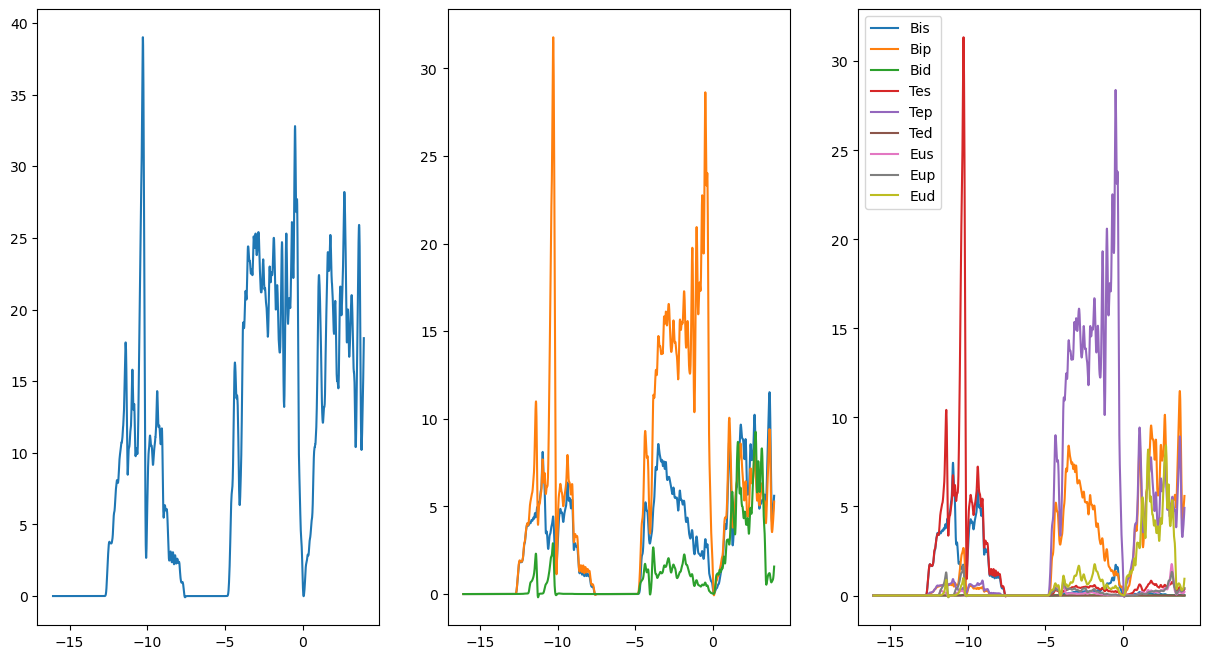

In [20]:
file = File()
file.load()
Ef = file.fermy_energy
file.DoS()
file.pdos()
plot = Plot()
fig, figura = plt.subplots(1,3,figsize = (15,8))
plot.dos(file.dos,subplot=True,ax =figura[0])
plot.pdos_atoms(file.pdos_per_atoms,subplot=True,ax = figura[1])
plot.pdos_orb(file.pdos_per_orb,subplot=True,ax = figura[2])



In [ ]:
bi = file.pdos_per_atoms['Bi']; Te = file.pdos_per_atoms['Te'];  Eu = file.pdos_per_atoms['Eu']
bi['E'] = file.pdos_per_atoms['Bi']['E']- Ef; Te['E'] = file.pdos_per_atoms['Te']['E'] - Ef; Eu['E'] = file.pdos_per_atoms['Eu']['E'] - Ef
bi = bi[bi['E']>-2]; Te = Te[Te['E']>-2]; Eu = Eu[Eu['E']>-2]

dos = file.dos
dos['E'] = dos['E'] -Ef

In [ ]:
fig, figura = plt.subplots(figsize = (12,10))
figura.plot(bi['E'],bi['ldos(E)'],label = 'Bi')
figura.plot(Te['E'],Te['ldos(E)'],label = 'Te')
figura.plot(Eu['E'],Eu['ldos(E)'],label = 'Eu')
figura.set_xlim(-2,2)
figura.legend()

In [ ]:

fig, figura = plt.subplots(figsize = (8,10))
figura.plot(bi['E'],bi['ldos(E)']+Te['ldos(E)'],label = 'Bi2Te3 - 0% dop',c ='black', linewidth = 3)
figura.plot(dos['E'],dos['dos']+35,label = 'Bi2Te3 - 4% dop',c = 'red',linewidth = 3)
#figura.plot(bi['E'],bi['ldos(E)'],label = 'Bi')
#figura.plot(Te['E'],Te['ldos(E)'],label = 'Te')
#figura.plot(Eu['E'],Eu['ldos(E)'],label = 'Eu')
figura.set_xlim(-1,1)
figura.legend(fontsize = 20)
figura.set_xticks(np.arange(-1,1.2,0.25),np.arange(-1,1.2,0.2),fontsize = 20)
figura.set_yticks([])
figura.set_xlabel('E - Ef  (eV)',fontsize = 20)
figura.set_ylabel('Density of States   (arb. unit)',fontsize = 20)
plt.savefig('dos_bi2te3_padrao_e_dopado.png',dpi = 300)
  

In [ ]:
dos = file.dos
plot = Plot()
plot.pdos([dos['E'],dos['dos']])
dos2 = file.add_dos('Bi2Te3/25-atomos/pdos/bi2te3_pdos.dat.pdos_tot')
list_dos = [[dos['E'],dos['dos']],[dos2['E'],dos2['dos']]]
plot.pdos(list_dos,n_dos=2)
